# Setup

## Packages

In [1]:
# data analysis
import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patches
from matplotlib.path import Path

2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2025-09-04 11:07:42 | [INFO] Downloading data from `https://omnipathdb.org/about?format=text`


## Functions

### scatterplots

#### shuffled embedding

In [6]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 1000000/adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

### barplots

In [7]:
def get_dataframe_barplot(
    adata,
    groupby,
    color_var: str | None = None,
    *,
    normalize_groupby: bool = True,
    normalize_color_var: bool = True,
    percent: bool = True,
) -> pd.DataFrame:
    df = sc.get.obs_df(
        adata=adata,
        keys=[groupby, color_var],
    )

    df = (
        df.groupby([groupby, color_var], observed=True).size().reset_index(name="count")
    )

    if normalize_groupby:
        df["count"] = df["count"] / (
            df.groupby(groupby, observed=True)["count"].transform("sum")
        )

    if normalize_color_var:
        df["count"] = df["count"] / (
            df.groupby(color_var, observed=True)["count"].transform("sum")
        )

    if percent and (normalize_color_var or normalize_groupby):
        df["count"] *= 100

    return df.pivot(index=groupby, columns=color_var, values="count").fillna(0)

### dotplot

In [ ]:
def plot_dotplot(
    adata,
    genes,
    groupby='leiden',
    layer="log1p_norm",
    categories_order=None,
    dot_sizes = (2, 150),
    figsize=None,
    dpi=200,
    palette="RdYlBu_r",
    savepath=None,
    legend_size=(1.2, 0.1),
    legend_wspace=0.1,
    legend_height_ratios=None,
    margin_dotplot=(0.05, 0.05),
    swap_axes=False
):

    if isinstance(genes, str):
        gene_sets = None
        genes = [genes]
    elif isinstance(genes, dict):
        gene_sets = genes
        genes = [gene for gene_set in gene_sets.values() for gene in gene_set]
    else:
        gene_sets = None
    
    df_expression = sc.get.obs_df(
        adata,
        keys=[groupby] + genes,
        layer=layer,
    )

    df_means = df_expression.groupby(groupby).mean()
    df_means_norm = df_means.sub(df_means.min(axis=1), axis=0).div(
        df_means.max(axis=1) - df_means.min(axis=1), axis=0
    )
    df_bool = df_expression.set_index(groupby) > 0
    df_sizes = df_bool.groupby(level=0).sum() / df_bool.groupby(level=0).count()
    df_means_sizes = (
        df_means_norm.reset_index()
        .melt(id_vars=groupby, var_name="gene", value_name="expression")
        .merge(
            df_sizes.reset_index().melt(
                id_vars=groupby, var_name="gene", value_name="size"
            ),
            on=[groupby, "gene"],
        )
    )

    df_means_sizes[groupby] = df_means_sizes[groupby].cat.reorder_categories(
        categories_order
    )
    df_size_legend = pd.DataFrame(
        np.linspace(
            round(df_means_sizes["size"].max(), 1) / 5,
            round(df_means_sizes["size"].max(), 1),
            5,
        )
        * 100,
        columns=["sizes"],
    )

    df_size_legend["x"] = [0, 1, 2, 3, 4]
    df_size_legend["y"] = [0, 0, 0, 0, 0]

    if swap_axes and figsize is None:
        figsize = (70 / 25.4, 199.902 / 25.4)
    elif figsize is None:
        figsize = (199.902 / 25.4, 70 / 25.4)

    fig = plt.figure(figsize=figsize, dpi=dpi, layout="constrained")
    fig_w, fig_h = fig.get_size_inches()
    
    gs_main = gridspec.GridSpec(1,2, figure=fig, width_ratios=[fig_w - legend_size[0], legend_size[0]], wspace=legend_wspace)

    if legend_height_ratios is None:
        spacer = (fig_h - legend_size[1])/3

        gs_legends = gridspec.GridSpecFromSubplotSpec(
            5, 1, subplot_spec=gs_main[1], height_ratios=[spacer*3, legend_size[1]*2, spacer*1, legend_size[1], spacer/2]
        )

    ax_dotplot = fig.add_subplot(gs_main[0])

    # --- Dotplot ---
    if swap_axes:
        sns.scatterplot(
            df_means_sizes,
            x=groupby,
            y='gene',
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_yticklabels():
            label.set_style("italic")
        for label in ax_dotplot.get_xticklabels():
            label.set_rotation(90)
    else:
        sns.scatterplot(
            df_means_sizes,
            x="gene",
            y=groupby,
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_xticklabels():
            label.set_style("italic")
            label.set_rotation(90)

    ax_dotplot.legend_.remove()
    ax_dotplot.set(ylabel="", xlabel="")

    if gene_sets is not None and swap_axes:
        new_coord = []
        y_ticklabels = []
        xmin, xmax = ax_dotplot.get_xlim()

        for text in ax_dotplot.get_yticklabels():
            y_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]
            
            gene_start_coord = y_ticklabels.index(gene_start)
            gene_end_coord = y_ticklabels.index(gene_end)
            
            new_coord.append((gene_start_coord-0.3, gene_end_coord+0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((xmax + 0.1, coord[0]))
            verts.append((xmax + 0.35, coord[0]))
            verts.append((xmax + 0.35, coord[1]))
            verts.append((xmax + 0.1, coord[1]))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                xmax + 1.3,
                coord_center,
                coord[2],
                ha="center",
                va="center",
                rotation=270,
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(path, facecolor="white", edgecolor="black", lw=1, clip_on=False)
        ax_dotplot.add_patch(patch)
    elif gene_sets is not None:
        new_coord = []
        x_ticklabels = []
        ymin, ymax = ax_dotplot.get_ylim()

        for text in ax_dotplot.get_xticklabels():
            x_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]
            
            gene_start_coord = x_ticklabels.index(gene_start)
            gene_end_coord = x_ticklabels.index(gene_end)
            
            new_coord.append((gene_start_coord-0.3, gene_end_coord+0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((coord[0], ymax - 0.1))
            verts.append((coord[0], ymax - 0.35))
            verts.append((coord[1], ymax - 0.35))
            verts.append((coord[1], ymax - 0.1))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                coord_center,
                ymax - 1,
                coord[2],
                ha="center",
                va="center",
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(path, facecolor="white", edgecolor="black", lw=1, clip_on=False)
        ax_dotplot.add_patch(patch)

    xmin, xmax = ax_dotplot.get_xlim()
    ymin, ymax = ax_dotplot.get_ylim()

    x_margin = (xmax - xmin) * margin_dotplot[0]
    y_margin = (ymax - ymin) * margin_dotplot[1]

    ax_dotplot.set_xlim(xmin - x_margin, xmax + x_margin)
    ax_dotplot.set_ylim(ymin - y_margin, ymax + y_margin)

    ax_size_legend = fig.add_subplot(gs_legends[1])

    sns.scatterplot(
        df_size_legend,
        x="x",
        y="y",
        size="sizes",
        sizes=dot_sizes,
        ax=ax_size_legend,
        legend=None,
        facecolors="grey",
        edgecolor="black",
    )
    ax_size_legend.set(ylabel="", xlabel="")
    ax_size_legend.set_xticks(df_size_legend["x"])
    ax_size_legend.set_xticklabels(df_size_legend["sizes"].astype(int))
    ax_size_legend.set_yticks([])
    ax_size_legend.spines[["right", "top", "left", "bottom"]].set_visible(False)
    ax_size_legend.margins(x=0.15, y=0.)
    ax_size_legend.set_title("Fraction of cells\nin group (%)", )

    ax_color_legend = fig.add_subplot(gs_legends[3])

    min_expression = round(df_means_sizes["expression"].min(), 1)
    max_expression = round(df_means_sizes["expression"].max(), 1)
    norm = Normalize(min_expression, max_expression)
    sm = ScalarMappable(norm=norm, cmap=palette)
    fig.colorbar(sm, cax=ax_color_legend, orientation="horizontal")
    ax_color_legend.set_xticks([min_expression, (min_expression + max_expression)/2, max_expression])
    ax_color_legend.set_title("Mean expression\nin group", )

    # --- Save or return ---
    if savepath:
        plt.savefig(savepath)
    return fig, ax_dotplot


## Dataset

Load dataset

In [8]:
data_path = "/home/david/Documents/My_Projects/Pillot_A04/data/"

adata = sc.read_h5ad(f"{data_path}anndata_figures_v2/41_lc_raw.h5ad")

In [9]:
adata.obs["timepoint"] = np.where(
    adata.obs["timepoint"] == "E185", "E18.5", adata.obs["timepoint"]
)
adata.obs["timepoint"] = (
    adata.obs["timepoint"]
    .astype("category")
    .cat.reorder_categories(["E18.5", "P1", "P7", "P21", "P60", "P90", "P100"])
)

## Colors

In [10]:
colors = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors[i] for i in range(15)}

In [11]:
colors = ["#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e"]
timepoints = ["E18.5", "P1", "P7", "P21", "P60", "P90", "P100"]
timepoint_colors = {timepoints[i]: colors[i] for i in range(len(timepoints))}

## Preprocessing

In [12]:
adata.X = adata.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 11:11:02,906 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 11:11:02 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 11:11:04,844 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 11:11:04 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 11:11:04,940 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 11:11:04 | [INFO] Iteration 1 of 10
2025-09-04 11:11:08,190 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 11:11:08 | [INFO] Iteration 2 of 10
2025-09-04 11:11:11,392 - harmonypy - INFO - Iteration 3 of 10
2025-09-04 11:11:11 | [INFO] Iteration 3 of 10
2025-09-04 11:11:14,572 - harmonypy - INFO - Converged after 3 iterations
2025-09-04 11:11:14 | [INFO] Converged after 3 iterations


# Analysis

## Cleanup

In [13]:
adata_cleaned_v1 = adata[~adata.obs["leiden"].isin(["3", "12", "13"])].copy()

In [14]:
adata_cleaned_v1.X = adata_cleaned_v1.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata_cleaned_v1,
    target_sum=1e4,
)

sc.pp.log1p(adata_cleaned_v1)

adata_cleaned_v1.layers["log1p_norm"] = adata_cleaned_v1.X.copy()

sc.pp.highly_variable_genes(
    adata_cleaned_v1, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata_cleaned_v1, max_value=10, zero_center=True)

adata_cleaned_v1.layers["scaled"] = adata_cleaned_v1.X.copy()

sc.pp.pca(
    adata_cleaned_v1,
)

sc.external.pp.harmony_integrate(adata_cleaned_v1, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_cleaned_v1,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_cleaned_v1,
)

sc.tl.leiden(adata_cleaned_v1, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 11:11:46,834 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 11:11:46 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 11:11:48,710 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 11:11:48 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 11:11:48,776 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 11:11:48 | [INFO] Iteration 1 of 10
2025-09-04 11:11:51,864 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 11:11:51 | [INFO] Iteration 2 of 10
2025-09-04 11:11:54,999 - harmonypy - INFO - Iteration 3 of 10
2025-09-04 11:11:54 | [INFO] Iteration 3 of 10
2025-09-04 11:11:57,923 - harmonypy - INFO - Converged after 3 iterations
2025-09-04 11:11:57 | [INFO] Converged after 3 iterations


## Clean-up v2

In [15]:
adata_cleaned_v2 = adata_cleaned_v1[~adata_cleaned_v1.obs["leiden"].isin(["4"])].copy()

In [16]:
adata_cleaned_v2.X = adata_cleaned_v2.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata_cleaned_v2,
    target_sum=1e4,
)

sc.pp.log1p(adata_cleaned_v2)

adata_cleaned_v2.layers["log1p_norm"] = adata_cleaned_v2.X.copy()

sc.pp.highly_variable_genes(
    adata_cleaned_v2, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata_cleaned_v2, max_value=10, zero_center=True)

adata_cleaned_v2.layers["scaled"] = adata_cleaned_v2.X.copy()

sc.pp.pca(
    adata_cleaned_v2,
)

sc.external.pp.harmony_integrate(adata_cleaned_v2, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata_cleaned_v2,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata_cleaned_v2,
)

sc.tl.leiden(adata_cleaned_v2, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-04 11:12:17,204 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-04 11:12:17 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-04 11:12:19,131 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-04 11:12:19 | [INFO] sklearn.KMeans initialization complete.
2025-09-04 11:12:19,199 - harmonypy - INFO - Iteration 1 of 10
2025-09-04 11:12:19 | [INFO] Iteration 1 of 10
2025-09-04 11:12:22,148 - harmonypy - INFO - Iteration 2 of 10
2025-09-04 11:12:22 | [INFO] Iteration 2 of 10
2025-09-04 11:12:25,178 - harmonypy - INFO - Iteration 3 of 10
2025-09-04 11:12:25 | [INFO] Iteration 3 of 10
2025-09-04 11:12:28,098 - harmonypy - INFO - Converged after 3 iterations
2025-09-04 11:12:28 | [INFO] Converged after 3 iterations


### Differentially expressed genes

In [17]:
sc.tl.rank_genes_groups(adata_cleaned_v2, groupby="leiden", method="wilcoxon", layer="log1p_norm")

deg_cleaned_v2_leiden_all = sc.get.rank_genes_groups_df(
    adata_cleaned_v2,
    group=None,
)

## Gene sets

#### import gene sets

In [ ]:
net = pd.read_csv('/path/to/gene_sets/gene_sets.csv')

#### AUCell

In [ ]:
dc.mt.aucell(
    data=adata_cleaned_v2,
    net=net,
)

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

## UMAP

In [ ]:
umap_dot_size = 250000/adata_cleaned_v2.n_obs
print(umap_dot_size)

14.092446448703495


In [ ]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

### Cluster

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


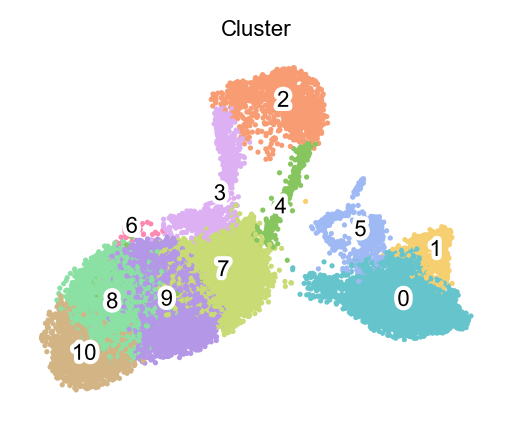

In [ ]:
margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    legend_fontsize="medium",
    legend_fontweight="normal",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

### Timepoint

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


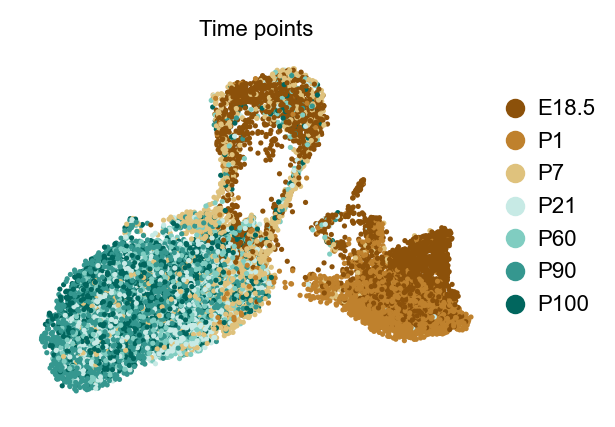

In [ ]:
margin_right = (
    20 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="timepoint",
    palette=timepoint_colors,
    ax=axes,
    title="Time points",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1 - (margin_right / fig_width), 0.5),
)

## Dotplots

<positron-console-cell-42>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-42>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


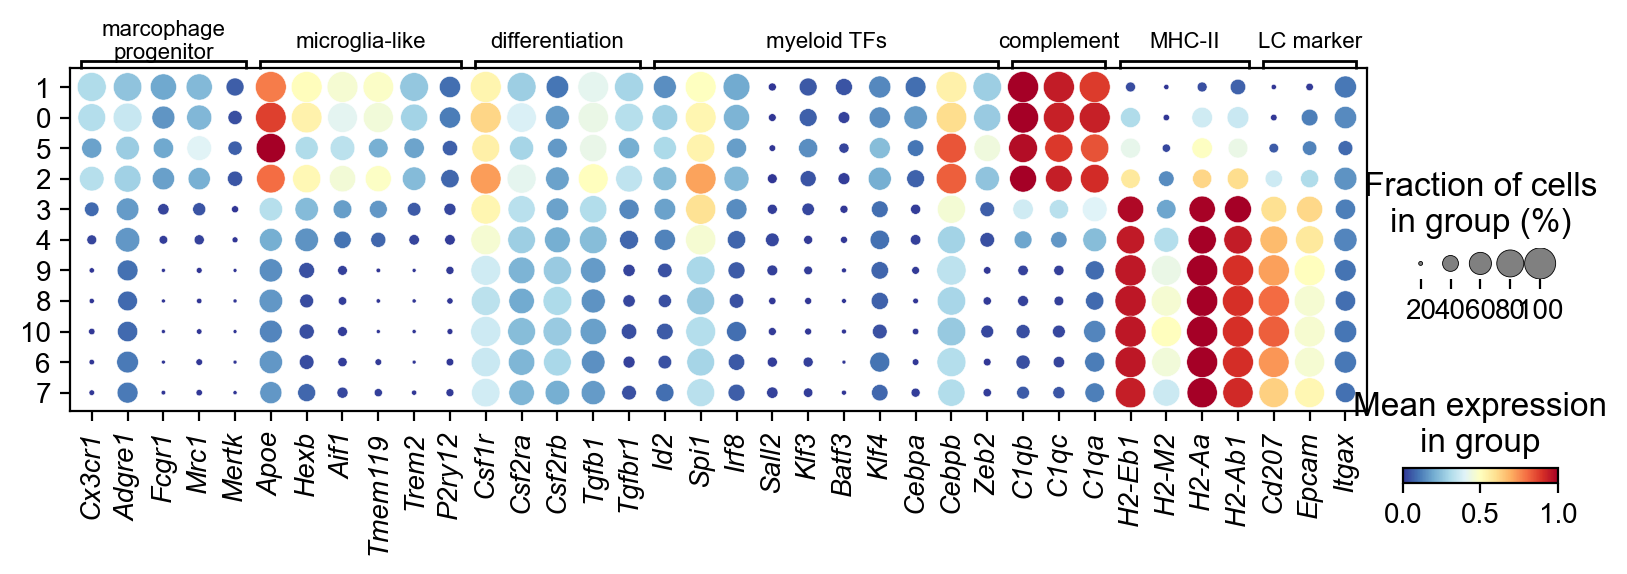

In [ ]:
genes = {
    'marcophage\nprogenitor': ['Cx3cr1',  'Adgre1', 'Fcgr1', 'Mrc1', 'Mertk'],
    'microglia-like': ['Apoe', 'Hexb', 'Aif1', 'Tmem119', 'Trem2', 'P2ry12',],
    'differentiation': ['Csf1r', 'Csf2ra', 'Csf2rb', 'Tgfb1', 'Tgfbr1', ],
    'myeloid TFs': ['Id2', 'Spi1', 'Irf8', 'Sall2', 'Klf3', 'Batf3', 'Klf4', 'Cebpa', 'Cebpb', 'Zeb2'],
    'complement': ['C1qb', 'C1qc', 'C1qa',],
    'MHC-II': ['H2-Eb1', 'H2-M2', 'H2-Aa', 'H2-Ab1',],
    'LC marker': ['Cd207', 'Epcam', 'Itgax', ]
}

order_cluster = ['1', '0', '5', '2', '3', '4', '9', '8', '10', '6', '7']

fig, ax_dotplot = plot_dotplot(
    adata_cleaned_v2,
    genes=genes,
    groupby='leiden',
    categories_order=order_cluster,
    swap_axes=False,
    figsize=(199.902 / 25.4, 70 / 25.4),
    legend_size=(1.1, 0.25),
    legend_wspace=0.,
    legend_height_ratios=None,
    dot_sizes=(2,125),
    margin_dotplot=(-0.03, 0.01)
)

## Boxplots gene sets

### AUCell

In [ ]:
df = sc.get.obs_df(adata_cleaned_v2, keys=["timepoint", "replicate"])

df = (
    df.merge(adata_cleaned_v2.obsm["score_aucell"], left_index=True, right_index=True)
    .groupby(["timepoint", "replicate"], observed=True)
    .mean()
    .reset_index()
)

<positron-console-cell-177>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-177>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-177>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-177>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


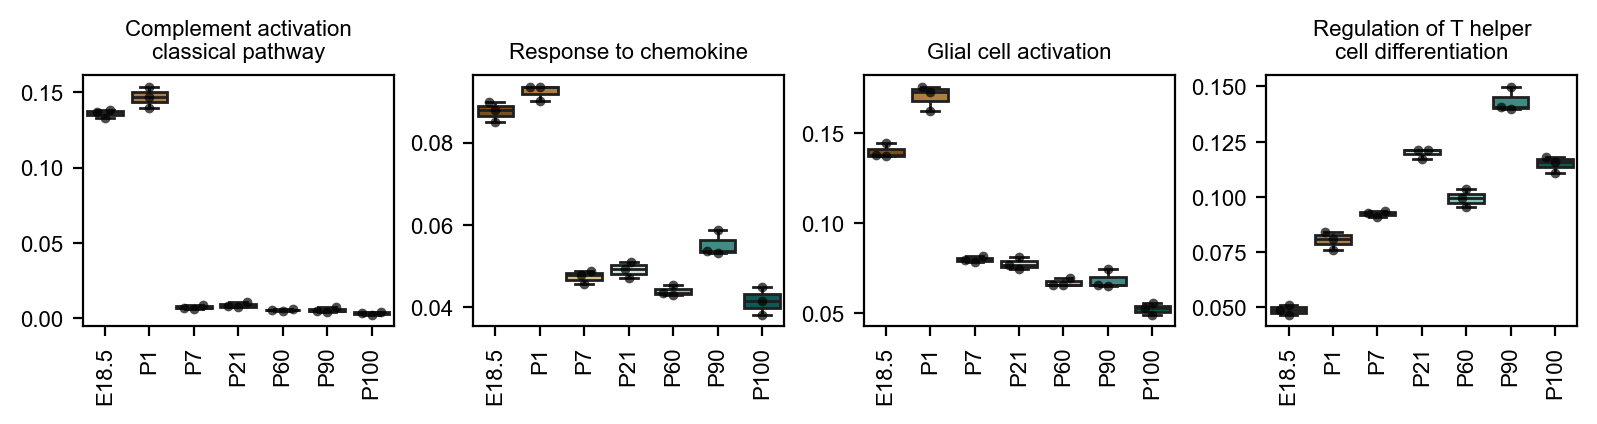

In [ ]:
gene_sets_subset = [
    "GOBP_COMPLEMENT_ACTIVATION_CLASSICAL_PATHWAY", 
    "GOBP_RESPONSE_TO_CHEMOKINE", 
    "GOBP_GLIAL_CELL_ACTIVATION", 
    "GOBP_REGULATION_OF_T_HELPER_CELL_DIFFERENTIATION", 
]

gene_set_title = {
    "GOBP_COMPLEMENT_ACTIVATION_CLASSICAL_PATHWAY": "Complement activation\nclassical pathway",
    "GOBP_RESPONSE_TO_CHEMOKINE": "Response to chemokine",
    "GOBP_GLIAL_CELL_ACTIVATION": "Glial cell activation",
    "GOBP_REGULATION_OF_T_HELPER_CELL_DIFFERENTIATION": "Regulation of T helper\ncell differentiation",
}

n_col = min(len(gene_sets_subset), 4)
n_row = int(np.ceil(len(gene_sets_subset) / n_col))

fig = plt.figure(
    figsize=(((199.902 / 4) / 25.4) * n_col, 51 / 25.4 * n_row),
    dpi=200,
    layout="constrained",
)

for gene in gene_sets_subset:
    ax = fig.add_subplot(n_row, n_col, gene_sets_subset.index(gene) + 1)

    sns.boxplot(
        data=df, x="timepoint", y=gene, hue="timepoint", palette=timepoint_colors
    )

    sns.swarmplot(data=df, x="timepoint", y=gene, color="black", alpha=0.7, size=3.5)

    ax.set_title(
        gene_set_title[gene],
    )

    ax.set_xlabel("")

    if gene_sets_subset.index(gene) == 0:
        ax.set_ylabel("AUCell score")
    else:
        ax.set_ylabel("")    

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Barplots

### cluster per timepoint

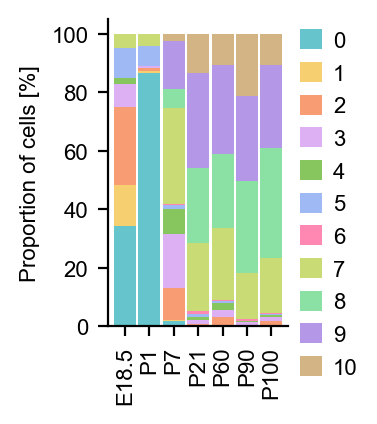

In [ ]:
fig, axes = plt.subplots(
    1, 1, figsize=(45 / 25.4, 51 / 25.4), dpi=200, layout="constrained"
)

p1 = get_dataframe_barplot(
    adata_cleaned_v2, groupby="timepoint", color_var="leiden", normalize_color_var=False
).plot(kind="bar", stacked=True, width=0.9, color=leiden_colors, ax=axes)

p1.legend(loc="center left", bbox_to_anchor=(1, 0.4), frameon=False)

p1.set_xlabel("")
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
p1.set_ylabel(
    "Proportion of cells [%]",
)

p1.spines["right"].set_visible(False)
p1.spines["top"].set_visible(False)

# Supplementary

## Csf1

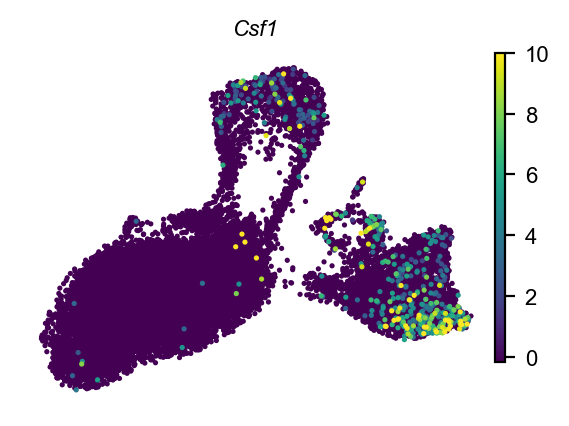

In [ ]:
margin_right = (
    12 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="Csf1",
    ax=axes,
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

axes.set_title(axes.get_title(), style="italic")

## Il34

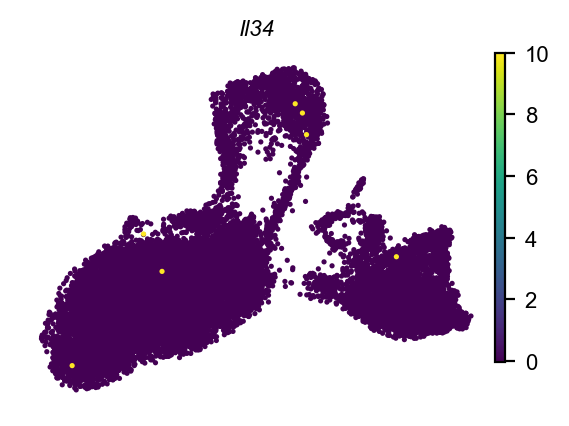

In [ ]:
margin_right = (
    12 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata_cleaned_v2,
    basis="X_umap",
    color="Il34",
    ax=axes,
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

axes.set_title(axes.get_title(), style="italic")

## Gene sets

In [ ]:
df = sc.get.obs_df(adata_cleaned_v2, keys=["timepoint", "replicate"])

df = (
    df.merge(adata_cleaned_v2.obsm["score_aucell"], left_index=True, right_index=True)
    .groupby(["timepoint", "replicate"], observed=True)
    .mean()
    .reset_index()
)

<positron-console-cell-178>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-178>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-178>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<positron-console-cell-178>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


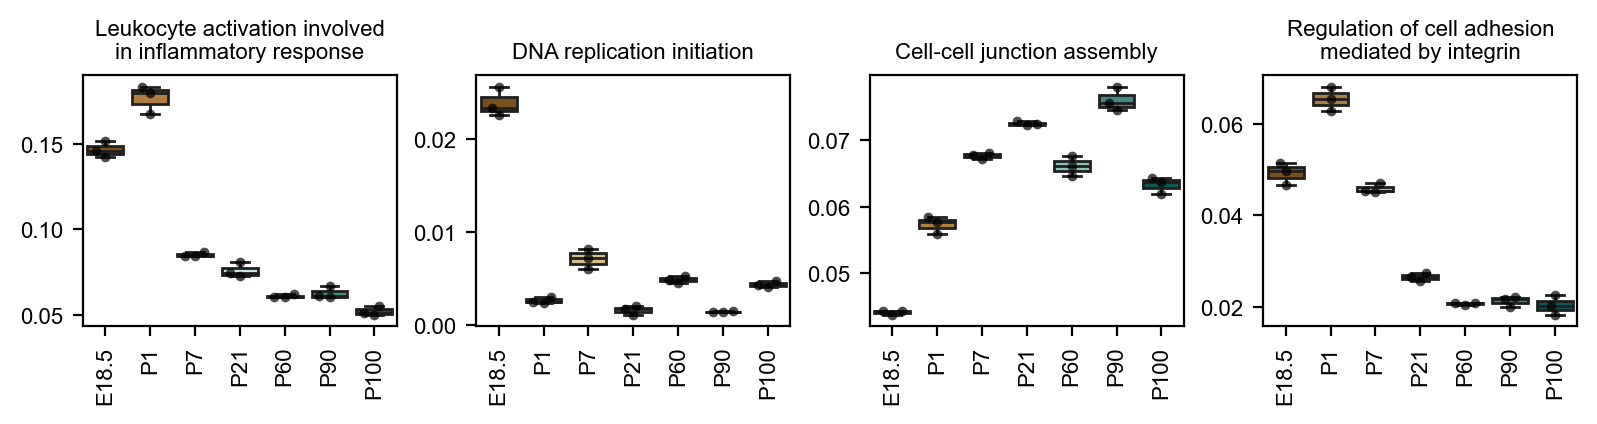

In [ ]:
gene_sets_subset = [
    "GOBP_LEUKOCYTE_ACTIVATION_INVOLVED_IN_INFLAMMATORY_RESPONSE", 
    "GOBP_DNA_REPLICATION_INITIATION", 
    "GOBP_CELL_CELL_JUNCTION_ASSEMBLY", 
    "GOBP_REGULATION_OF_CELL_ADHESION_MEDIATED_BY_INTEGRIN", 
]

gene_set_title = {
    "GOBP_LEUKOCYTE_ACTIVATION_INVOLVED_IN_INFLAMMATORY_RESPONSE": "Leukocyte activation involved\nin inflammatory response",
    "GOBP_DNA_REPLICATION_INITIATION": "DNA replication initiation",
    "GOBP_CELL_CELL_JUNCTION_ASSEMBLY": "Cell-cell junction assembly",
    "GOBP_REGULATION_OF_CELL_ADHESION_MEDIATED_BY_INTEGRIN": "Regulation of cell adhesion\nmediated by integrin",
}

n_col = min(len(gene_sets_subset), 4)
n_row = int(np.ceil(len(gene_sets_subset) / n_col))

fig = plt.figure(
    figsize=(((199.902 / 4) / 25.4) * n_col, 51 / 25.4 * n_row),
    dpi=200,
    layout="constrained",
)

for gene in gene_sets_subset:
    ax = fig.add_subplot(n_row, n_col, gene_sets_subset.index(gene) + 1)

    sns.boxplot(
        data=df, x="timepoint", y=gene, hue="timepoint", palette=timepoint_colors
    )

    sns.swarmplot(data=df, x="timepoint", y=gene, color="black", alpha=0.7, size=3.5)

    ax.set_title(
        gene_set_title[gene],
    )

    ax.set_xlabel("")

    if gene_sets_subset.index(gene) == 0:
        ax.set_ylabel("AUCell score")
    else:
        ax.set_ylabel("")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Dotplot

In [ ]:
top5_genes = (
    deg_cleaned_v2_leiden_all
    .groupby('group', observed=True)
    .apply(
        lambda x: x.nlargest(5, 'scores'),
        include_groups=False
    )
    .reset_index()
    .loc[:, ['group', 'names']]
    .groupby('group', observed=True)['names']
    .apply(list)
    .to_dict()
)

<positron-console-cell-54>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-54>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


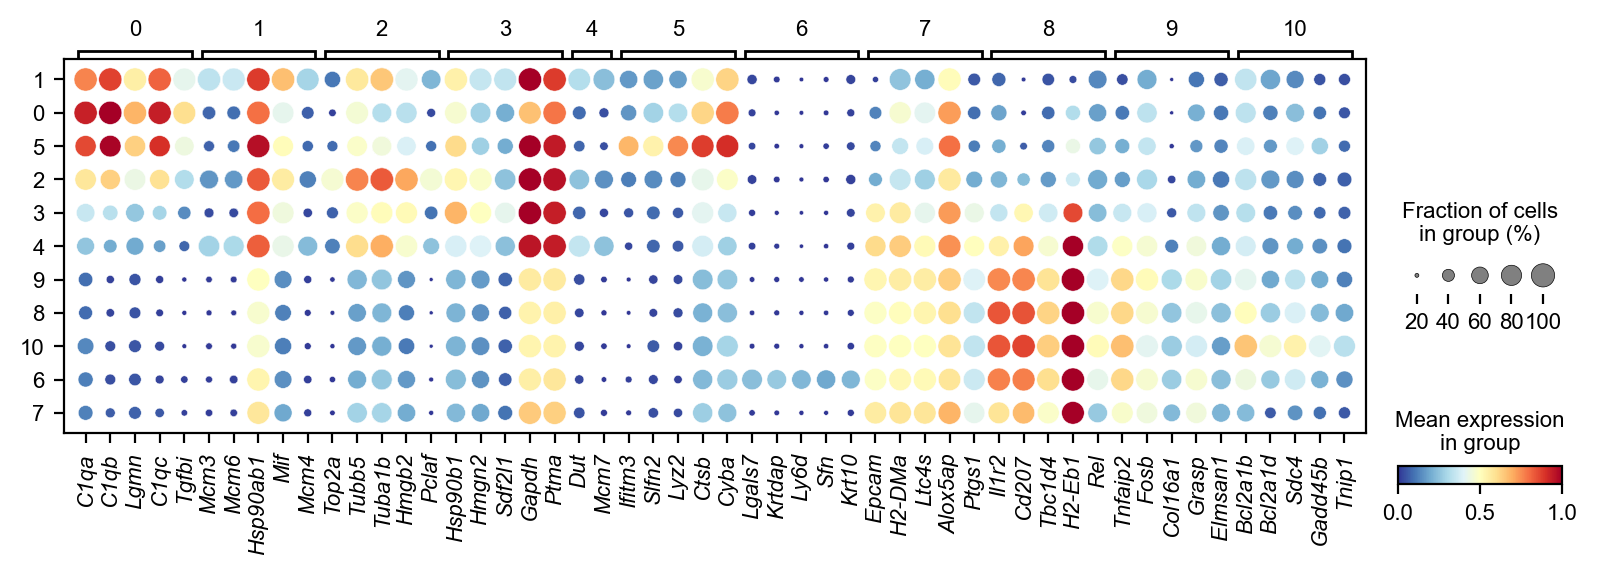

In [ ]:
order_cluster = ['1', '0', '5', '2', '3', '4', '9', '8', '10', '6', '7']

fig, ax_dotplot = plot_dotplot(
    adata_cleaned_v2,
    genes=top5_genes,
    groupby='leiden',
    categories_order=order_cluster,
    swap_axes=False,
    figsize=(199.902 / 25.4, 70 / 25.4),
    legend_size=(1.1, 0.25),
    legend_wspace=0.,
    legend_height_ratios=None,
    dot_sizes=(2,70),
    margin_dotplot=(-0.03, 0.01)
)

# Saving

In [ ]:
# adata_cleaned_v2.write_h5ad(f"{data_path}lc_cleaned.h5ad")